In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Nacitanie iris datasetu
# X - features (data)
# y - triedy (setosa, versicolor, virginica)
# Strukturovany dataset (riadky, stlpce)
iris = load_iris()
X = iris.data
y = iris.target

epochs=100

In [3]:
print("Dataset shape:", X.shape)
print("Labels:", set(y))
print("Classes:", iris['target_names'])

iris_df = pd.DataFrame(X, columns=iris.feature_names)
iris_df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)
iris_df.head()

Dataset shape: (150, 4)
Labels: {0, 1, 2}
Classes: ['setosa' 'versicolor' 'virginica']


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [4]:
# Rozdelenie datasetu na trenovaciu a testovaciu cast (test_size = 0.3 znamena 30% testovacia cast)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [5]:
# Vizualizacia datasetu pomocou bodoveho grafu
def create_scatter_plot(X, y, features, title):
    # Set up the figure and axis
    plt.figure(figsize=(12, 10))
    plt.suptitle(title, fontsize=16)

    # Create a scatter plot for each pair of features
    plot_number = 1
    for i in range(len(features)):
        for j in range(len(features)):
            if i < j:
                plt.subplot(2, 3, plot_number)
                for target in np.unique(y):
                    subset = X[y == target]
                    plt.scatter(subset[:, i], subset[:, j], label=iris.target_names[target])
                plt.xlabel(features[i])
                plt.ylabel(features[j])
                plt.legend()
                plot_number += 1

    plt.show()

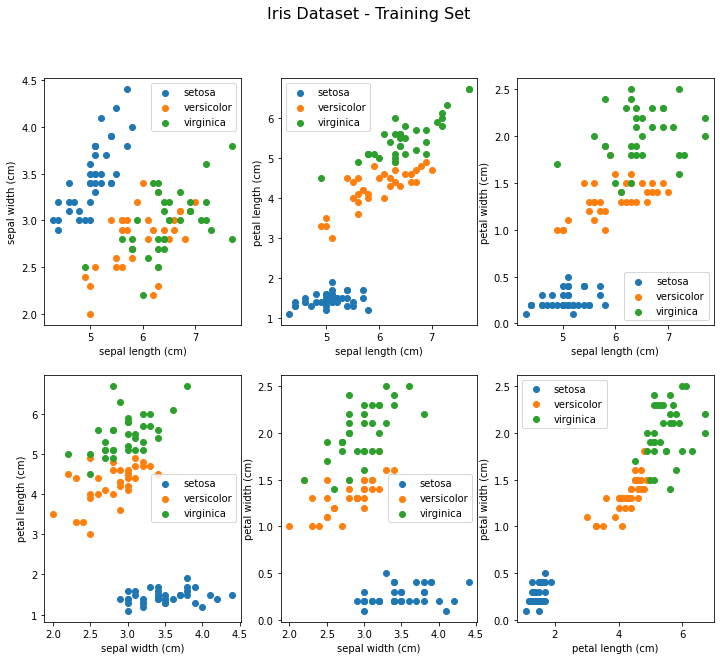

In [6]:
# Vizualizacia trenovacieho setu
create_scatter_plot(X_train, y_train, iris.feature_names, 'Iris Dataset - Training Set')

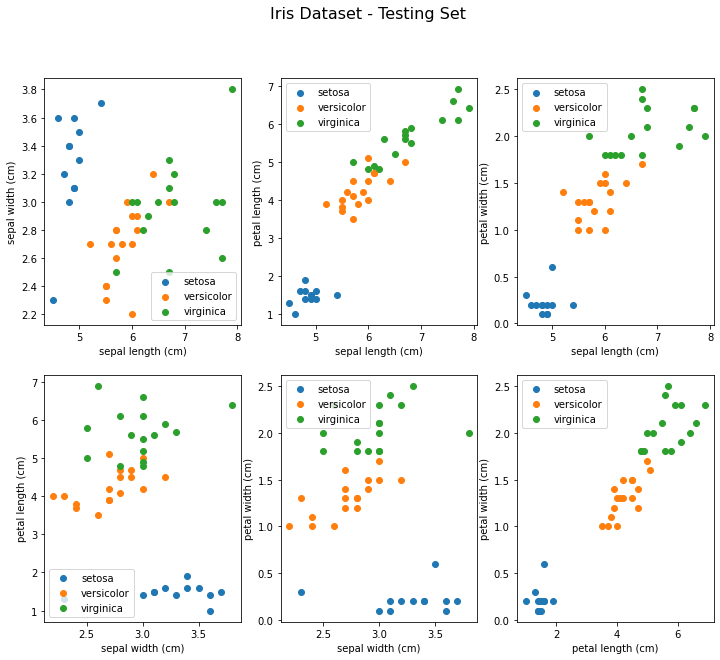

In [7]:
# Vizualizacia testovacieho setu
create_scatter_plot(X_test, y_test, iris.feature_names, 'Iris Dataset - Testing Set')

In [8]:
# Standardize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
# Konvertovanie na tensory
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [10]:
# Vytvorenie dataset objektov
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Vytvorenie loaderov pre loadovanie dat pocas treningu
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [11]:
# MLP Model: Likely to perform well given the simplicity and small size of the Iris dataset. MLPs are generally good for tabular data.
# CNN Model: Might be less effective since the Iris dataset is not image data, and CNNs are primarily designed for spatial data. However, with proper adaptation, it can still perform reasonably well.
# RNN Model: RNNs are designed for sequential data, which the Iris dataset is not. Its performance might be less intuitive and could vary depending on how the input data is structured and fed into the model.

In [12]:
# Definovanie MLP Modelu
class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        # 4 input features, 8 neuronov
        self.fc1 = nn.Linear(4, 10)
        # Hidden layer - 10 neuronov
        self.fc2 = nn.Linear(10, 10)
        # output layer, 3 output features
        self.fc3 = nn.Linear(10, 3)

    # Metoda pre predikciu
    def forward(self, x):
        x = self.fc1(x)
        # Aplikovanie relu pre hidder layer
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
# Definovanie CNN Modelu
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, 3)
        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(16, 3)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [14]:
# Definovanie RNN Modelu
class RNNModel(nn.Module):
    def __init__(self):
        super(RNNModel, self).__init__()
        self.rnn = nn.LSTM(input_size=1, hidden_size=8, batch_first=True)
        self.fc = nn.Linear(8, 3)

    def forward(self, x):
        x = x.unsqueeze(2)  # Add a feature dimension
        x, _ = self.rnn(x)
        x = x[:, -1, :]  # Take the last time step
        x = self.fc(x)
        return x

In [15]:
# Trenovaci loop, pouziva back propagation
def train(model, criterion, optimizer, epoch_number):
    lossesmean = []
    loss_vall_arr = []
    acc_arr = []
    
    for epoch in range(epoch_number):
        losses = 0
        for data in train_loader:
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses += loss.detach().numpy()
            loss.backward()
            optimizer.step()
        lossesmean.append(losses/len(train_loader))
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')
        
        acc, lossvall = evaluate_model(model, train_loader)
        acc_arr.append(acc)
        loss_vall_arr.append(lossvall)
        
    return lossesmean, loss_vall_arr, acc_arr

In [16]:
# Funkcia pre vyhodnotenie modelu na testovacich datach
def evaluate_model(model, data_loader):
    model.eval()
    total = 0
    correct = 0
    losses = 0
    lossesmean = []
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses += loss.detach().numpy()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    lossesmean.append(losses/len(train_loader))
    accuracy = 100 * correct / total
    return accuracy, lossesmean

In [17]:
def visualise(loss_vall_arr, acc_arr, epochs):
    epochs = range(0, epochs)
    plt.plot(epochs, loss_vall_arr, label='valid')
    plt.plot(epochs,acc_arr, label='acc')
    plt.legend()
    plt.show()

MLP
Epoch 1, Loss: 1.2393110990524292
Epoch 2, Loss: 1.2638850212097168
Epoch 3, Loss: 1.1566565036773682
Epoch 4, Loss: 0.16371473670005798
Epoch 5, Loss: 0.18473872542381287
Epoch 6, Loss: 0.050315286964178085
Epoch 7, Loss: 0.9743427038192749
Epoch 8, Loss: 0.4687597453594208
Epoch 9, Loss: 0.01573433354496956
Epoch 10, Loss: 0.22350692749023438
Epoch 11, Loss: 0.006985527463257313
Epoch 12, Loss: 0.5090949535369873
Epoch 13, Loss: 0.024533940479159355
Epoch 14, Loss: 0.003899709088727832
Epoch 15, Loss: 0.3825456202030182
Epoch 16, Loss: 0.29634031653404236
Epoch 17, Loss: 0.15827824175357819
Epoch 18, Loss: 0.025374814867973328
Epoch 19, Loss: 0.5626552104949951
Epoch 20, Loss: 0.000523430178873241
Epoch 21, Loss: 0.0014529397012665868
Epoch 22, Loss: 0.1147344782948494
Epoch 23, Loss: 0.001662064460106194
Epoch 24, Loss: 0.10818972438573837
Epoch 25, Loss: 0.3068811297416687
Epoch 26, Loss: 0.06215348094701767
Epoch 27, Loss: 0.0001811817055568099
Epoch 28, Loss: 0.04781882837414

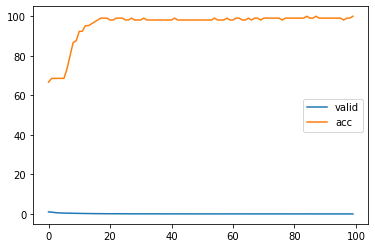

CNN
Epoch 1, Loss: 1.0895659923553467
Epoch 2, Loss: 0.6592389941215515


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


Epoch 3, Loss: 1.0653926134109497
Epoch 4, Loss: 0.37364649772644043
Epoch 5, Loss: 1.0342187881469727
Epoch 6, Loss: 0.3249069154262543
Epoch 7, Loss: 0.5286746621131897
Epoch 8, Loss: 0.15684913098812103
Epoch 9, Loss: 0.15296098589897156
Epoch 10, Loss: 0.23694312572479248
Epoch 11, Loss: 0.0599454864859581
Epoch 12, Loss: 0.8324461579322815
Epoch 13, Loss: 0.07921083271503448
Epoch 14, Loss: 0.055120714008808136
Epoch 15, Loss: 0.7943831086158752
Epoch 16, Loss: 0.04403429850935936
Epoch 17, Loss: 0.5610934495925903
Epoch 18, Loss: 0.22866663336753845
Epoch 19, Loss: 0.062019601464271545
Epoch 20, Loss: 0.09789208322763443
Epoch 21, Loss: 0.009196068160235882
Epoch 22, Loss: 0.43341052532196045
Epoch 23, Loss: 0.17387080192565918
Epoch 24, Loss: 0.5347638726234436
Epoch 25, Loss: 0.0015893458621576428
Epoch 26, Loss: 0.20234668254852295
Epoch 27, Loss: 0.04958895593881607
Epoch 28, Loss: 0.017332512885332108
Epoch 29, Loss: 0.23493178188800812
Epoch 30, Loss: 0.0023036866914480925


In [18]:
mlp_model = MLPModel()
cnn_model = CNNModel()
rnn_model = RNNModel()

# Definovanie loss funkcie a optimalizatorov
criterion = nn.CrossEntropyLoss()

mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

# Trenovacie modely
print("MLP")
losses_mean, loss_vall_arr, acc_arr  = train(mlp_model, criterion, mlp_optimizer, epochs)
visualise(loss_vall_arr, acc_arr, epochs)
print("CNN")
lossesmean, loss_vall_arr, acc_arr  = train(cnn_model, criterion, cnn_optimizer, epochs)
print("RNN")
lossesmean, loss_vall_arr, acc_arr  = train(rnn_model, criterion, rnn_optimizer, epochs)

# Evaluacia modelov
#mlp_accuracy = evaluate_model(mlp_model, test_loader)
#cnn_accuracy = evaluate_model(cnn_model, test_loader)
#rnn_accuracy = evaluate_model(rnn_model, test_loader)

In [19]:
def classify_samples(model, tensor):
    # Pass the samples through the model
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        predictions = model(new_samples_tensor)
        _, predicted_classes = torch.max(predictions, 1)
    
    # Print the class names
    for i, index in enumerate(predicted_classes):
        print(f"Sample {i+1}: {iris['target_names'][index]}")

In [20]:
#print(f'MLP Accuracy: {mlp_accuracy}%')
#print(f'CNN Accuracy: {cnn_accuracy}%')
#print(f'RNN Accuracy: {rnn_accuracy}%')
print("================================")

# Testuje nové vzorky na MLP modeli, transformuje ich, konvertuje na tenzory, predpovedá triedy a vypisuje názvy predpovedaných tried

new_samples = np.array([
    [5.1, 3.5, 1.4, 0.2],
    [6.7, 3.0, 5.2, 2.3],
    [5.9, 3.0, 4.2, 1.5],
    [6.1, 2.9, 4.7, 1.4],
    [4.6, 3.4, 1.4, 0.3]
])

# Scale the samples
new_samples_scaled = scaler.transform(new_samples)

# Konvertovanie na tensor
new_samples_tensor = torch.tensor(new_samples_scaled, dtype=torch.float32)

print("MLP")
classify_samples(mlp_model, new_samples_tensor)
print("CNN")
classify_samples(cnn_model, new_samples_tensor)
print("RNN")
classify_samples(rnn_model, new_samples_tensor)

MLP
Sample 1: setosa
Sample 2: virginica
Sample 3: versicolor
Sample 4: versicolor
Sample 5: setosa
CNN
Sample 1: setosa
Sample 2: virginica
Sample 3: versicolor
Sample 4: versicolor
Sample 5: setosa
RNN
Sample 1: setosa
Sample 2: virginica
Sample 3: versicolor
Sample 4: versicolor
Sample 5: setosa


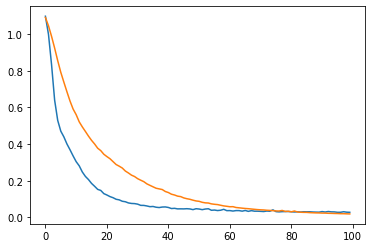

In [21]:
epochs = range(0, 100)
plt.plot(epochs,losses_mean, label='train')
plt.plot(epochs, loss_vall_arr, label='valid')
#plt.yscale('log')

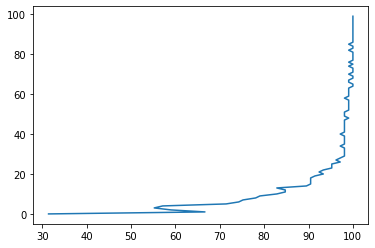

In [22]:
plt.plot(acc_arr, epochs)